<a href="https://colab.research.google.com/github/vpapoglou/Machine-Learning-Auth/blob/main/ML_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# 1. ΕΠΕΞΕΡΓΑΣΙΑ ΔΕΔΟΜΕΝΩΝ (Data Processing)

# Δεδομένα
train_features = pd.read_csv('train_hh_features.csv')
train_gt = pd.read_csv('train_hh_gt.csv')
test_features = pd.read_csv('test_hh_features.csv')

# Πρόσθεση στήλης για διάκριση δεδομένων train/test
train_features['is_train'] = 1
test_features['is_train'] = 0

# Concatenation (Ένωση όλων σε ένα μεγάλο DataFrame)
all_data = pd.concat([train_features, test_features], axis=0)

# Συμπλήρωση Κενών (Imputation)
# Για αριθμητικά: Μεσος όρος (Median)
# Για κατηγορίες: Δημιουργία κατηγορίας 'missing'
# Εξαιρούνται τα 'survey_id', 'hhid', 'is_train' από τον υπολογισμό του median
cols_to_exclude = ['survey_id', 'hhid', 'is_train']
num_cols = all_data.select_dtypes(include=[np.number]).columns.difference(cols_to_exclude)
cat_cols = all_data.select_dtypes(exclude=[np.number]).columns

all_data[num_cols] = all_data[num_cols].fillna(all_data[num_cols].median())
all_data[cat_cols] = all_data[cat_cols].fillna('missing')

# One-Hot Encoding (Μετατροπή κειμένου σε αριθμούς)
# Με το drop_first αφαιρούμε την μια περιττή στήλη π.χ. drop Female column αφού αν Male = 0 τότε αυτόματα είναι Female
all_data_encoded = pd.get_dummies(all_data, columns=cat_cols, drop_first=True)

# Χωρισμός σε Train και Test
# Χρησιμοποιούμε τη στήλη 'is_train' και μετά την διαγράφουμε (drop)
df_train_final = all_data_encoded[all_data_encoded['is_train'] == 1].copy()
df_test_final = all_data_encoded[all_data_encoded['is_train'] == 0].copy()

# Προετοιμασία Train Set (X και y)
# Merge χαρακτηριστικών του train set με τον στόχο (κατανάλωση)
# To Join γίνεται πάνω στα survey_id και hhid
df_train_merged = pd.merge(df_train_final, train_gt, on=['survey_id', 'hhid'])

# Δημιουργία X (Features) και y (Target)
# Αφαίρεση IDs, Target γιατί δεν προσφέρουν πληροφορία για την πρόβλεψη και το is_train
# Αφαίρεση του cons_ppp17 από το Χ καθώς θέλουμε να το προβλέψουμε
X = df_train_merged.drop(columns=['cons_ppp17', 'survey_id', 'hhid', 'is_train'])
y = df_train_merged['cons_ppp17']

# Προετοιμασία Test Set (για το submission αργότερα)
# Διατήρηση των IDs για το αρχείο υποβολής
test_ids = df_test_final[['survey_id', 'hhid']].copy()
# Αφαίρεση IDs και 'is_train' για να είναι ίδιο με το X
X_submission = df_test_final.drop(columns=['survey_id', 'hhid', 'is_train'])

# Έλεγχος
print(f"Train set shape (X): {X.shape} (γραμμές, στήλες)")
print(f"Test set shape (X_submission): {X_submission.shape} (γραμμές, στήλες)")
# Πρέπει οι στήλες να είναι ίδιες

Train set shape (X): (104234, 173) (γραμμές, στήλες)
Test set shape (X_submission): (103023, 173) (γραμμές, στήλες)


In [8]:
# 2. ΑΝΑΛΥΣΗ ΔΕΔΟΜΕΝΩΝ (Data Analysis)

# Συσχέτιση (Correlation) με το στόχο
numeric_df = df_train_merged.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['cons_ppp17'].sort_values(ascending=False)

print("\n--- Top 5 Θετικές Συσχετίσεις ---")
print(correlations.head(6)) # Το πρώτο είναι η ίδια η στήλη στόχος
print("\n--- Top 5 Αρνητικές Συσχετίσεις ---")
print(correlations.tail(5))


--- Top 5 Θετικές Συσχετίσεις ---
cons_ppp17       1.000000
utl_exp_ppp17    0.445317
sfworkershh      0.369261
region7          0.300099
region1          0.129630
region2          0.064078
Name: cons_ppp17, dtype: float64

--- Top 5 Αρνητικές Συσχετίσεις ---
hsize      -0.272773
region5    -0.309193
strata     -0.445995
com              NaN
is_train         NaN
Name: cons_ppp17, dtype: float64


In [9]:
# 3. ΕΦΑΡΜΟΓΗ ΑΛΓΟΡΙΘΜΩΝ

# Χωρισμός σε Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Κανονικοποίηση/Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Μοντέλο 1: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Μοντέλο 2: Random Forest (Ensemble - Bagging)
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train) # Τα δέντρα δεν χρειάζονται κανονικοποίηση
y_pred_rf = rf.predict(X_test)

# Μοντέλο 3: Gradient Boosting (Ensemble - Boosting)
gb = GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Μοντέλο 4: Deep Learning (MLP)
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2), # Για αποφυγή overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1) # Linear activation γιατί κάνουμε Regression
])
mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])
mlp.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0)
y_pred_dl = mlp.predict(X_test_scaled).flatten()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



--- Αποτελέσματα Σύγκρισης ---
| Model               |     MSE |    MAE |     R2 |
|:--------------------|--------:|-------:|-------:|
| Linear Regression   | 47.2298 | 4.1256 | 0.5299 |
| Random Forest       | 39.5487 | 3.6348 | 0.6064 |
| Gradient Boosting   | 36.3639 | 3.4570 | 0.6381 |
| Deep Learning (MLP) | 36.1981 | 3.3140 | 0.6397 |


/tmp/ipython-input-1146074803.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=df_results, palette='viridis')


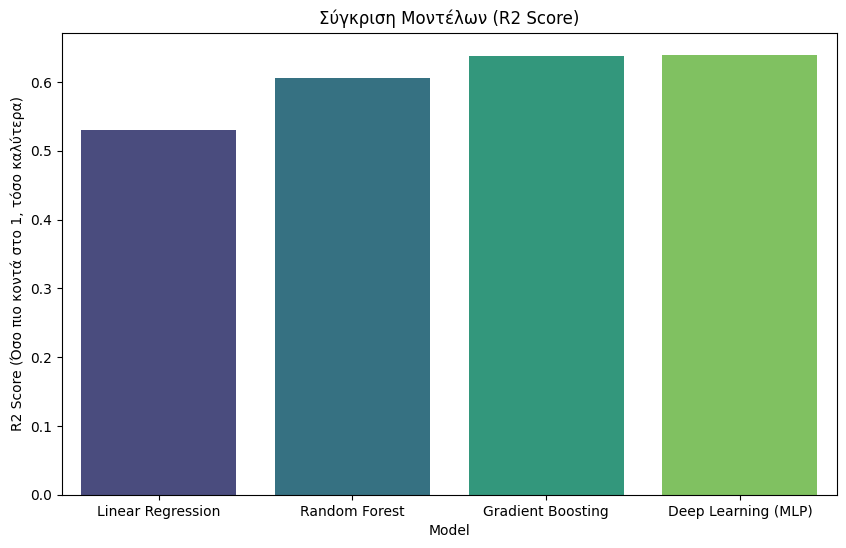

In [10]:
# 4. ΣΥΓΚΡΙΣΗ ΚΑΙ ΑΠΟΤΕΛΕΣΜΑΤΑ

def evaluate(name, y_true, y_pred):
    return {
        'Model': name,
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

results = [
    evaluate("Linear Regression", y_test, y_pred_lr),
    evaluate("Random Forest", y_test, y_pred_rf),
    evaluate("Gradient Boosting", y_test, y_pred_gb),
    evaluate("Deep Learning (MLP)", y_test, y_pred_dl)
]

df_results = pd.DataFrame(results)
print("\n--- Αποτελέσματα Σύγκρισης ---")
print(df_results.to_markdown(index=False, floatfmt=".4f"))

# Γράφημα
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=df_results, palette='viridis')
plt.title('Σύγκριση Μοντέλων (R2 Score)')
plt.ylabel('R2 Score (Όσο πιο κοντά στο 1, τόσο καλύτερα)')
plt.show()

In [12]:
import zipfile

# 1. ΠΑΡΑΓΩΓΗ ΠΡΟΒΛΕΨΕΩΝ
# Προβλέψεις με το MLP στα δεδομένα του Test set
predictions = mlp.predict(X_submission, verbose=0).flatten()

# Προσωρινό DataFrame με τα IDs και τις προβλέψεις
submission_df = test_ids.copy()
submission_df['cons_ppp17'] = predictions


# 2. ΑΡΧΕΙΟ 1: predicted_household_consumption.csv
# Μετονομασία στηλών για το παραδοτέο σύμφωνα με τις οδηγίες
cons_submission = submission_df.rename(columns={
    'hhid': 'household_id'
})

# Αποθήκευση
cons_submission.to_csv('predicted_household_consumption.csv', index=False)

# 3. ΑΡΧΕΙΟ 2: predicted_poverty_distribution.csv
# Εξαγωγή των thresholds από το αρχείο εκπαίδευσης για να πάρουμε τα ονόματα των στηλών
train_rates = pd.read_csv('train_rates_gt.csv')
threshold_cols = [col for col in train_rates.columns if col != 'survey_id']
# Εξάγουμε τα νούμερα από τα ονόματα των στηλών (π.χ. 'pct_hh_below_3.17' -> 3.17)
threshold_values = [float(col.split('_')[-1]) for col in threshold_cols]

results = []

# Ομαδοποίηση ανά survey_id (γιατί θέλουμε ποσοστά ανά έρευνα)
grouped = submission_df.groupby('survey_id')

for survey, group in grouped:
    survey_preds = group['cons_ppp17'].values

    row = {'survey_id': survey}

    # Για κάθε όριο φτώχειας, υπολογίζουμε το ποσοστό των νοικοκυριών που είναι κάτω από αυτό
    for thresh_val, col_name in zip(threshold_values, threshold_cols):
        # Υπολογισμός ποσοστού: (Πλήθος προβλέψεων < όριο) / Συνολικό πλήθος
        percentage = (survey_preds < thresh_val).mean()
        row[col_name] = percentage

    results.append(row)

# Δημιουργία DataFrame και αποθήκευση
dist_submission = pd.DataFrame(results)
dist_submission.to_csv('predicted_poverty_distribution.csv', index=False)

# 4. ΣΥΜΠΙΕΣΗ ΣΕ ZIP (Για το upload)
with zipfile.ZipFile('submission.zip', 'w') as zf:
    zf.write('predicted_household_consumption.csv')
    zf.write('predicted_poverty_distribution.csv')